In [15]:
# Standard libraries
import sys

# 3rd party libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay
import SimpleITK as sitk

# Our libraries
#sys.path.append('../../')
#from gui.gui_shared import auto_contrast

## Show correspondences

In [16]:
def remove_duplicates(list1: np.ndarray, list2: np.ndarray):
    """
    Remove duplicate elements from list1 and the corresponding elements from list2.
    
    Parameters:
    - list1: The first list from which duplicates will be removed.
    - list2: The second list from which elements will be removed corresponding to the removed elements in list1.
    
    Returns:
    - list1_unique: The list1 with duplicates removed.
    - list2_filtered: The list2 with elements removed corresponding to the removed elements in list1.
    """
    seen = set()
    list1_unique = []
    list2_filtered = []
    
    for item1, item2 in zip(list1, list2):
        item1_tuple = tuple(item1)
        if item1_tuple not in seen:
            seen.add(item1_tuple)
            list1_unique.append(item1)
            list2_filtered.append(item2)
    
    return np.array(list1_unique), np.array(list2_filtered)

Moving points shape: (790120, 3)
[[  1.  73. 216.]
 [  1.  73. 216.]
 [  1.  74. 216.]
 ...
 [526. 284. 271.]
 [526. 284. 272.]
 [526. 284. 272.]]

Fixed points shape: (790120, 3)
[[  1. 176. 230.]
 [  1. 177. 230.]
 [  1. 178. 231.]
 ...
 [526. 274. 261.]
 [526. 274. 262.]
 [526. 274. 263.]]

Unique moving points in volume: 389967
Unique fixed points in volume: 790120

Checking slice 350
Number of moving points for slice 350 : 2484
[[ 17 178]
 [ 17 179]
 [ 18 172]
 ...
 [271 355]
 [271 357]
 [271 357]]

Number of fixed points for slice 350 : 2484
[[ 10 173]
 [ 10 174]
 [ 10 175]
 ...
 [270 355]
 [270 356]
 [270 357]]

Number of unique moving points for slice 350 : 1326
[[ 17 178]
 [ 17 179]
 [ 18 172]
 ...
 [271 354]
 [271 355]
 [271 357]]

Number of unique fixed points for slice 350 : 1326
[[ 10 173]
 [ 10 174]
 [ 10 175]
 ...
 [270 354]
 [270 355]
 [270 356]]



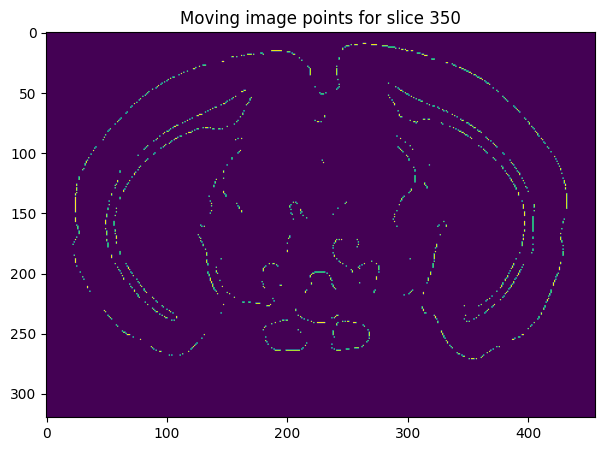

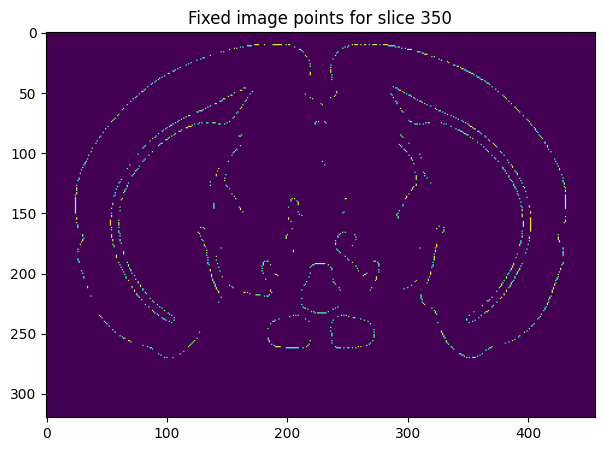

In [17]:
folder_name = "1_3i"

# Load in the moving and fixed points
mpoints_path = folder_name + "/mpoints.npy"
fpoints_path = folder_name + "/fpoints.npy"
mpoints = np.load(mpoints_path)
fpoints = np.load(fpoints_path)

# Print out the moving and fixed point information
print("Moving points shape:", mpoints.shape)
print(mpoints)
print("\nFixed points shape:", fpoints.shape)
print(fpoints)

# Turn the moving and fixed points into sets to remove duplicates
mpoints_set = set([tuple(p) for p in mpoints])
fpoints_set = set([tuple(p) for p in fpoints])
print("\nUnique moving points in volume:", len(mpoints_set))
print("Unique fixed points in volume:", len(fpoints_set))

# Rescaled height, width, and z
width = 456
height = 320
z = 528

# Create a binary image to show the correspondences
curr_idx = 350
print("\nChecking slice", curr_idx)

# Get relevant corresponding image points
curr_mpoints = np.array([point[1:] for point in mpoints if point[0] == curr_idx])
curr_mpoints = curr_mpoints.astype(int)
curr_fpoints = np.array([point[1:] for point in fpoints if point[0] == curr_idx])
curr_fpoints = curr_fpoints.astype(int)
print("Number of moving points for slice", curr_idx, ":", len(curr_mpoints))
print(curr_mpoints)
print("\nNumber of fixed points for slice", curr_idx, ":", len(curr_fpoints))
print(curr_fpoints)

curr_mpoints_unique, curr_fpoints_unique = remove_duplicates(curr_mpoints, curr_fpoints)
print("\nNumber of unique moving points for slice", curr_idx, ":", len(curr_mpoints_unique))
print(curr_mpoints_unique)
print("\nNumber of unique fixed points for slice", curr_idx, ":", len(curr_fpoints_unique))
print(curr_fpoints_unique)
print()

# Fill in binary image
binary_image_moving = np.zeros((height, width), dtype=bool)
binary_image_fixed = np.zeros((height, width), dtype=bool)
for point in curr_mpoints_unique:
    binary_image_moving[point[0], point[1]] = 1
for point in curr_fpoints_unique:
    binary_image_fixed[point[0], point[1]] = 1
    
# Show binary image
plt.figure(figsize=(10, 5))
plt.imshow(binary_image_moving, cmap='viridis')
plt.title('Moving image points for slice ' + str(curr_idx))
plt.show()

# Show binary image
plt.figure(figsize=(10, 5))
plt.imshow(binary_image_fixed, cmap='viridis')
plt.title('Fixed image points for slice ' + str(curr_idx))
plt.show()

### Plot Delauany triangulation
Code to validate Delaunay triangulations below

In [18]:
def do_lines_intersect(p1, q1, p2, q2):
    """
    Check if two line segments (p1, q1) and (p2, q2) intersect.
    
    Parameters:
    - p1, q1: Endpoints of the first line segment.
    - p2, q2: Endpoints of the second line segment.
    
    Returns:
    - intersect: True if the line segments intersect, False otherwise.
    """
    def orientation(p, q, r):
        """
        Calculate the orientation of the ordered triplet (p, q, r).
        """
        val = (q[1] - p[1]) * (r[0] - q[0]) - (q[0] - p[0]) * (r[1] - q[1])
        if val == 0:
            return 0
        return 1 if val > 0 else 2

    def on_segment(p, q, r):
        # Check y and x coordinates to see if q is between p and r, if so, return True
        if min(p[0], r[0]) <= q[0] <= max(p[0], r[0]) and min(p[1], r[1]) <= q[1] <= max(p[1], r[1]):
            return True
        return False

    o1 = orientation(p1, q1, p2)
    o2 = orientation(p1, q1, q2)
    o3 = orientation(p2, q2, p1)
    o4 = orientation(p2, q2, q1)

    if o1 != o2 and o3 != o4:
        return True

    # Also if points are collinear, check if they are on the segment, if so return True. 
    if o1 == 0 and on_segment(p1, p2, q1):
        return True
    if o2 == 0 and on_segment(p1, q2, q1):
        return True
    if o3 == 0 and on_segment(p2, p1, q2):
        return True
    if o4 == 0 and on_segment(p2, q1, q2):
        return True

    return False


def is_point_in_triangle(pt, v1, v2, v3):
    """
    Check if a point is inside a triangle using barycentric coordinates.
    
    Parameters:
    - pt: The point to check (x, y).
    - v1, v2, v3: The vertices of the triangle (x, y).
    
    Returns:
    - True if the point is inside the triangle, False otherwise.
    """
    # Check if the point is the same as any of the vertices
    if np.array_equal(pt, v1) or np.array_equal(pt, v2) or np.array_equal(pt, v3):
        return False
    
    # Compute the signed area of the triangle using the determinant formed by coordinate of these points
    def sign(p1, p2, p3):
        return (p1[0] - p3[0]) * (p2[1] - p3[1]) - (p2[0] - p3[0]) * (p1[1] - p3[1])
    
    # pt, v1 and v2
    d1 = sign(pt, v1, v2)
    # pt, v2 and v3
    d2 = sign(pt, v2, v3)
    # pt, v3 and v1
    d3 = sign(pt, v3, v1)

    # Check if any of the signed areas are negative or positive
    has_neg = (d1 < 0) or (d2 < 0) or (d3 < 0) # True if any of d1 d2 or d3 is negative
    has_pos = (d1 > 0) or (d2 > 0) or (d3 > 0) # True if any of d1, d2, or d3 is positive

    # If has_nag and has_pos are both True, then the point is outside the triangle because it is on different edges
    # If both are False, then the point is inside the triangle
    return not (has_neg and has_pos)  



def triangles_overlap(tri1, tri2):
    """
    Check if two triangles overlap by checking if any of their edges intersect,
    excluding shared edges or vertices.
    
    Parameters:
    - tri1: The vertices of the first triangle.
    - tri2: The vertices of the second triangle.
    
    Returns:
    - overlap: True if the triangles overlap, False otherwise.
    """
    edges1 = [(tri1[i], tri1[(i + 1) % 3]) for i in range(3)]
    edges2 = [(tri2[i], tri2[(i + 1) % 3]) for i in range(3)]
    
    for edge1 in edges1:
        for edge2 in edges2:
            if do_lines_intersect(edge1[0], edge1[1], edge2[0], edge2[1]):
                # Check if the edges are not shared
                if not (np.array_equal(edge1[0], edge2[0]) or np.array_equal(edge1[0], edge2[1]) or
                        np.array_equal(edge1[1], edge2[0]) or np.array_equal(edge1[1], edge2[1])):
                    return True
                
    # Check if any vertex of tri1 is inside tri2
    for vertex in tri1:
        if is_point_in_triangle(vertex, *tri2):
            return True
    
    # Check if any vertex of tri2 is inside tri1
    for vertex in tri2:
        if is_point_in_triangle(vertex, *tri1):
            return True
                
    return False


def check_overlapping_triangles(points, triangulation, npy_path="output/"):
    """
    Check if a Delaunay triangulation has overlapping triangles.
    
    Parameters:
    - points: The set of points used for the triangulation.
    - triangulation: The Delaunay triangulation object.
    
    Returns:
    - overlap: True if there are overlapping triangles, False otherwise.
    """
    num_overlapping_triangles = 0
    num_checks = 0
    overlap = False
    overlapping_triangles = []  # Store overlapping triangles for debugging
    
    triangle_stats = {}
    
    # Check for overlapping triangles
    for i, simplex1 in enumerate(triangulation.simplices):
        tri1 = points[simplex1]
        
        overlapped = []
        
        # Simplex to check against
        for j, simplex2 in enumerate(triangulation.simplices):
            if i >= j:  # Avoid checking the same pair twice
                continue
            tri2 = points[simplex2]
            num_checks += 1
            
            # If triangles overlap, increment the count
            if triangles_overlap(tri1, tri2):
                # Print the first time
                if num_overlapping_triangles == 0:
                    tri1_str = ", ".join(map(str, tri1))
                    tri2_str = ", ".join(map(str, tri2))
                    print(f"\tTriangles overlap on triangle {tri1_str} and triangle {tri2_str}.")
                    print("\t...")
                    
                # Add to list of overlapping triangles
                overlapping_triangles.append((tri1, tri2))
                overlap = True
                num_overlapping_triangles += 1
                
                # Add index to stats for current simplex index
                overlapped.append(j)
                #return True
                
        # Add to stats for current simplex index
        triangle_stats[i] = overlapped
    # Print the results
    print("\tNumber of overlapping triangle checks failed:", num_overlapping_triangles, "/", num_checks)
    # Save the overlapping triangles
    if npy_path is not None:
        np.save(npy_path + "overlapping_triangles.npy", overlapping_triangles)
        np.save(npy_path + "triangle_stats.npy", triangle_stats)
    return overlap


def validate_triangulation(points, tri):
    """
    Validate a triangulation.
    
    Parameters:
    - points: The set of points used for the triangulation.
    
    Returns:
    - valid: True if the triangulation is valid, False otherwise.
    """
    # Check for overlapping triangles
    print("Checking for no overlapping triangles...")
    if check_overlapping_triangles(points, tri):
        print("\tOverlapping triangles check FAILED.")
        return False
    print("\tOverlapping triangles check PASSED.")
    return True

Try an example Delaunay triangulation where I swap some indexes around

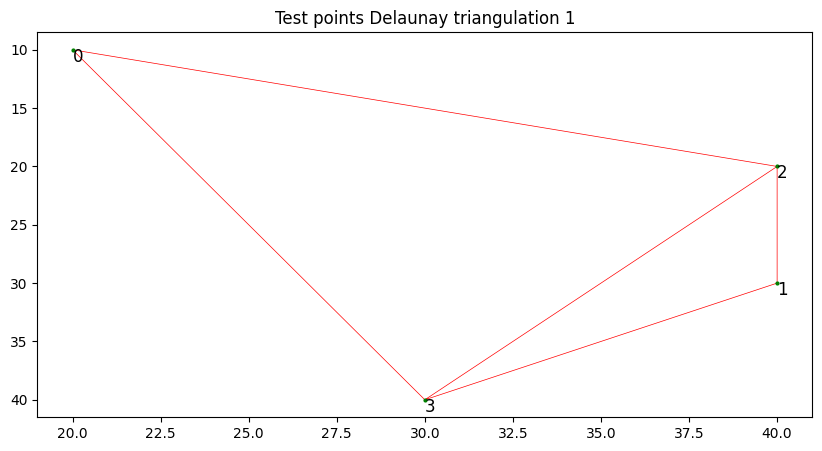

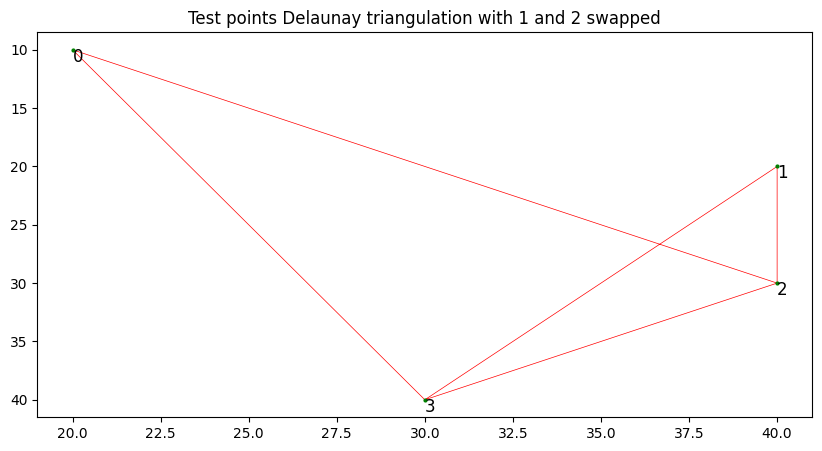

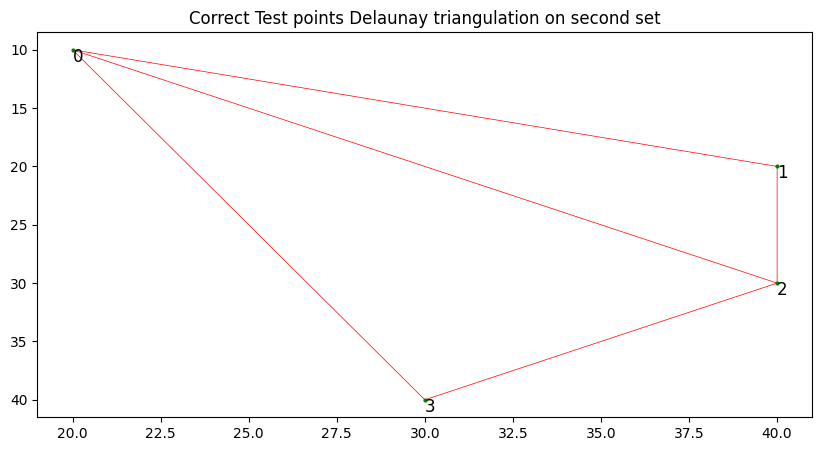

In [5]:
from matplotlib.patches import Circle


test_pts = np.array([
    [10, 20],  # 0
    [30, 40],  # 1
    [20, 40],  # 2
    [40, 30]]) # 3

triang = Delaunay(test_pts)

plt.figure(figsize=(10, 5))
plt.plot(test_pts[:, 1], test_pts[:, 0], 'go', markersize=2)
for i in range(len(test_pts)):
    pt = test_pts[i]
    plt.text(pt[1], pt[0] + 1, str(i), fontsize=12)
plt.triplot(test_pts[:, 1], test_pts[:, 0], triang.simplices, color='red', linewidth=0.5)
plt.gca().invert_yaxis()  # Invert the y-axis
plt.title('Test points Delaunay triangulation 1')
#circle = Circle(center, radius, color='blue', fill=False, linewidth=1.5)
#plt.gca().add_patch(circle)
plt.show()

# Swap 1 and 2 around
test_pts_2 = np.array([
    test_pts[0],
    test_pts[2],
    test_pts[1],  # 1
    test_pts[3]]) # 3

plt.figure(figsize=(10, 5))
plt.plot(test_pts_2[:, 1], test_pts_2[:, 0], 'go', markersize=2)
for i in range(len(test_pts_2)):
    pt = test_pts_2[i]
    plt.text(pt[1], pt[0] + 1, str(i), fontsize=12)
plt.triplot(test_pts_2[:, 1], test_pts_2[:, 0], triang.simplices, color='red', linewidth=0.5)
plt.gca().invert_yaxis()  # Invert the y-axis
plt.title('Test points Delaunay triangulation with 1 and 2 swapped')
# Plot circumcircle
#center = (25, 25)
#radius = 15.811388300841896
#circle = Circle(center, radius, color='blue', fill=False, linewidth=1.5)
#plt.gca().add_patch(circle)
plt.show()


triang_2 = Delaunay(test_pts_2)
plt.figure(figsize=(10, 5))
plt.plot(test_pts_2[:, 1], test_pts_2[:, 0], 'go', markersize=2)
for i in range(len(test_pts_2)):
    pt = test_pts_2[i]
    plt.text(pt[1], pt[0] + 1, str(i), fontsize=12)
plt.triplot(test_pts_2[:, 1], test_pts_2[:, 0], triang_2.simplices, color='red', linewidth=0.5)
plt.gca().invert_yaxis()  # Invert the y-axis
plt.title('Correct Test points Delaunay triangulation on second set')
plt.show()

In [6]:
# Validate the Delaunay triangulation
print("Checking test point set 1 triangulation (expected to pass)...")
_ = validate_triangulation(test_pts, triang)
print()
print("Checking test point set 1 triangulation on test point set 2 (expected to fail)...")
_ = validate_triangulation(test_pts_2, triang)
print()
print("Checking test point set 2 triangulation (expected to pass)...")
_ = validate_triangulation(test_pts_2, triang_2)

Checking test point set 1 triangulation (expected to pass)...
Checking for no overlapping triangles...
	Number of overlapping triangle checks failed: 0 / 1
	Overlapping triangles check PASSED.

Checking test point set 1 triangulation on test point set 2 (expected to fail)...
Checking for no overlapping triangles...
	Triangles overlap on triangle [20 40], [30 40], [40 30] and triangle [40 30], [30 40], [10 20].
	...
	Number of overlapping triangle checks failed: 1 / 1
	Overlapping triangles check FAILED.

Checking test point set 2 triangulation (expected to pass)...
Checking for no overlapping triangles...
	Number of overlapping triangle checks failed: 0 / 1
	Overlapping triangles check PASSED.


### Perform Delaunay triangulation on all unfiltered moving points and show the triangulation

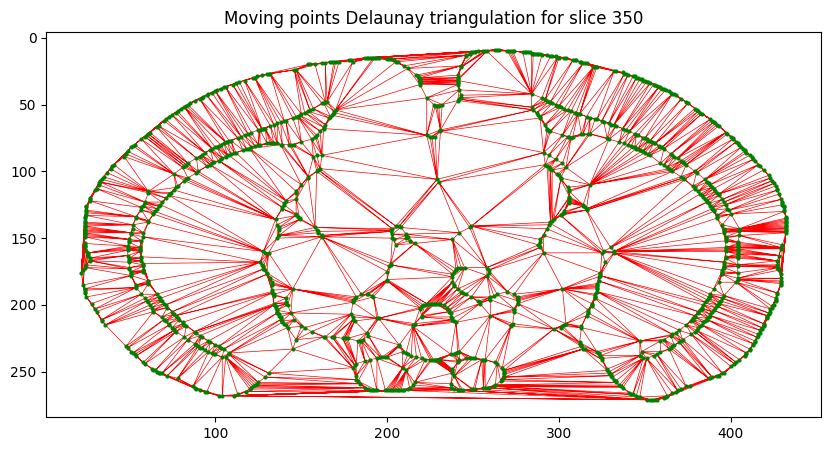

In [19]:
curr_moving = curr_mpoints_unique  # The set of points to triangulate on
# Do triangulation on moving points and show it on moving points
tri = Delaunay(curr_moving)

# Plot the Delaunay triangulation
plt.figure(figsize=(10, 5))
plt.triplot(tri.points[:, 1], tri.points[:, 0], tri.simplices, color='red', linewidth=0.5)
plt.plot(tri.points[:, 1], tri.points[:, 0], 'go', markersize=2)
plt.gca().invert_yaxis()  # Invert the y-axis
plt.title('Moving points Delaunay triangulation for slice ' + str(curr_idx))
plt.show()

In [20]:
# Validate the Delaunay triangulation
print("Checking moving points Delaunay triangulation...")
_ = validate_triangulation(curr_moving, tri)
print()

Checking moving points Delaunay triangulation...
Checking for no overlapping triangles...
	Number of overlapping triangle checks failed: 0 / 3229611
	Overlapping triangles check PASSED.



In [21]:
len(tri.coplanar)  # Points exluded from triangulation because they are coplanar

0

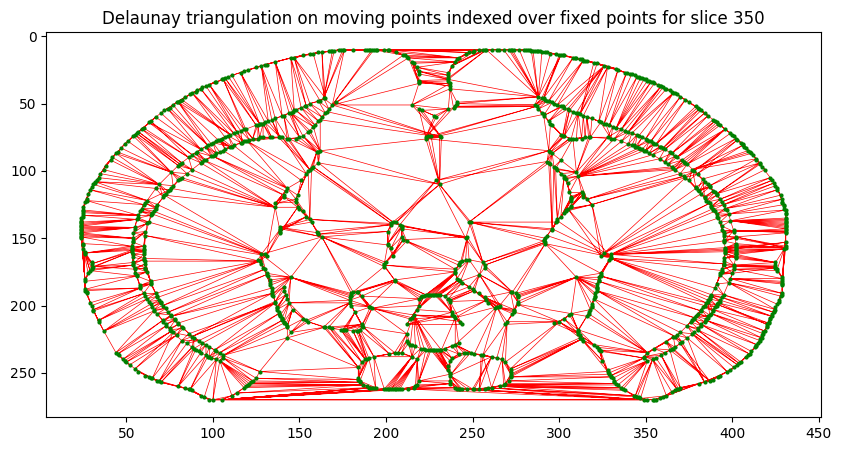

In [22]:
curr_fixed = curr_fpoints_unique  # The set of points to triangulate on

# Do triangulation on moving points and show it on fixed points
plt.figure(figsize=(10, 5))
plt.triplot(curr_fixed[:, 1], curr_fixed[:, 0], tri.simplices, color='red', linewidth=0.5)
plt.plot(curr_fixed[:, 1], curr_fixed[:, 0], 'go', markersize=2)
plt.gca().invert_yaxis()  # Invert the y-axis
plt.title('Delaunay triangulation on moving points indexed over fixed points for slice ' + str(curr_idx))
plt.show()

In [23]:
# Validate the Delaunay triangulation
print("Checking moving points Delaunay triangulation over fixed points...")
_ = validate_triangulation(curr_fixed, tri)
print()

Checking moving points Delaunay triangulation over fixed points...
Checking for no overlapping triangles...
	Triangles overlap on triangle [248 399], [249 397], [252 393] and triangle [236 410], [238 408], [237 409].
	...
	Number of overlapping triangle checks failed: 10648 / 3229611
	Overlapping triangles check FAILED.



len(tri.simplices)
len(tri.points)
np.save("output/tri.npy", tri)
np.save("output/curr_fixed.npy", curr_fixed)
np.save("output/curr_moving.npy", curr_moving)

In [13]:
# Get the triangulation simplices information
fixed_stats_path = "output/triangle_stats.npy"

# Load the fixed stats
fixed_stats = np.load(fixed_stats_path, allow_pickle=True).item()

# Sort the fixed_stats dictionary by the length of the values
lengths_dict = {key: len(value) for key, value in fixed_stats.items()}
sorted_lengths = dict(sorted(lengths_dict.items(), key=lambda item: item[1], reverse=True))
sorted_fixed_stats = {key: fixed_stats[key] for key in sorted_lengths.keys()}

# Print the sorted dictionary
print("Sorted dictionary by descending value:")
for key, value in sorted_lengths.items():
    print(f"{key}: {value}")
print()

# Print the sorted fixed_stats dictionary
print("Sorted fixed_stats dictionary:")
for key, value in sorted_fixed_stats.items():
    print(f"{key}: {value}")
print()

Sorted dictionary by descending value:
101: 40
183: 28
6: 23
108: 23
1098: 21
5: 20
475: 20
478: 20
99: 19
25: 18
453: 18
1319: 18
24: 17
50: 17
107: 17
358: 17
1222: 16
1610: 16
2253: 16
2255: 16
27: 15
93: 15
100: 15
736: 15
2254: 15
179: 14
356: 14
357: 14
476: 14
716: 14
825: 14
1223: 14
1320: 14
22: 13
41: 13
333: 13
348: 13
640: 13
684: 13
735: 13
823: 13
1112: 13
1980: 13
133: 12
160: 12
161: 12
224: 12
266: 12
268: 12
355: 12
639: 12
717: 12
784: 12
939: 12
1043: 12
1207: 12
1389: 12
1456: 12
1682: 12
38: 11
116: 11
132: 11
225: 11
269: 11
818: 11
942: 11
943: 11
1046: 11
1099: 11
1113: 11
1226: 11
1227: 11
1325: 11
1382: 11
1458: 11
1751: 11
4: 10
14: 10
18: 10
30: 10
111: 10
169: 10
421: 10
479: 10
686: 10
916: 10
944: 10
1047: 10
1268: 10
1383: 10
1422: 10
1488: 10
1650: 10
2036: 10
2077: 10
37: 9
49: 9
88: 9
109: 9
211: 9
223: 9
242: 9
252: 9
260: 9
261: 9
360: 9
641: 9
644: 9
715: 9
725: 9
737: 9
739: 9
745: 9
746: 9
819: 9
923: 9
963: 9
1044: 9
1119: 9
1143: 9
1326: 9
204

Simplex 1: [581 577 798]
	Am: [135.  24.]
	Bm: [134.  24.]
	Cm: [176.  22.]
Simplex 2: [657 677 798]
	Am: [156.  24.]
	Bm: [155.  24.]
	Cm: [176.  22.]


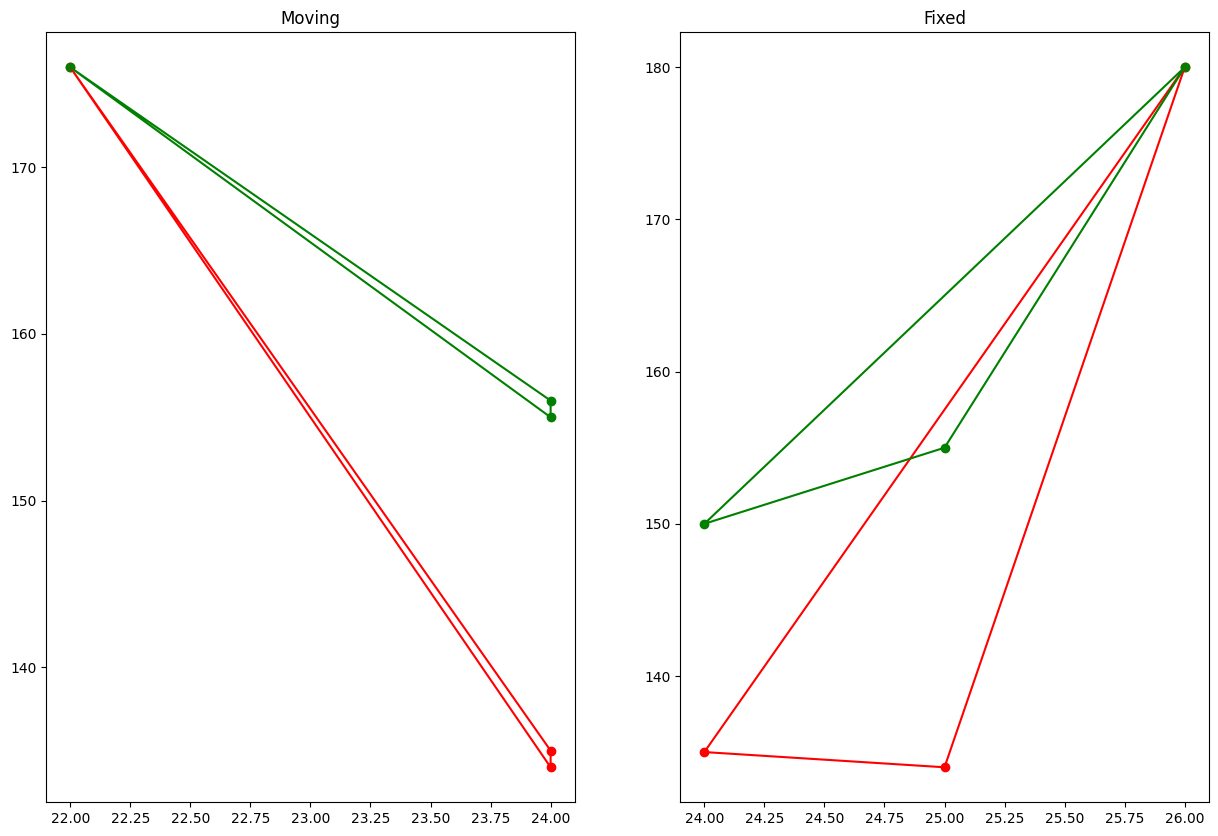

In [14]:
def show_triangles(tri, fpts, idx1, idx2):
    simplex1 = tri.simplices[idx1]
    simplex2 = tri.simplices[idx2]
    
    # Moving points
    tri1_A = tri.points[simplex1[0]]
    tri1_B = tri.points[simplex1[1]]
    tri1_C = tri.points[simplex1[2]]
    tri2_A = tri.points[simplex2[0]]
    tri2_B = tri.points[simplex2[1]]
    tri2_C = tri.points[simplex2[2]]
    
    tri1_pts_y = np.array([tri1_A[1], tri1_B[1], tri1_C[1], tri1_A[1]])
    tri1_pts_x = np.array([tri1_A[0], tri1_B[0], tri1_C[0], tri1_A[0]])
    tri2_pts_y = np.array([tri2_A[1], tri2_B[1], tri2_C[1], tri2_A[1]])
    tri2_pts_x = np.array([tri2_A[0], tri2_B[0], tri2_C[0], tri2_A[0]])
    
    # Fixed points
    tri1_Af = fpts[simplex1[0]]
    tri1_Bf = fpts[simplex1[1]]
    tri1_Cf = fpts[simplex1[2]]
    tri2_Af = fpts[simplex2[0]]
    tri2_Bf = fpts[simplex2[1]]
    tri2_Cf = fpts[simplex2[2]]
    
    tri1_pts_yf = np.array([tri1_Af[1], tri1_Bf[1], tri1_Cf[1], tri1_Af[1]])
    tri1_pts_xf = np.array([tri1_Af[0], tri1_Bf[0], tri1_Cf[0], tri1_Af[0]])
    tri2_pts_yf = np.array([tri2_Af[1], tri2_Bf[1], tri2_Cf[1], tri2_Af[1]])
    tri2_pts_xf = np.array([tri2_Af[0], tri2_Bf[0], tri2_Cf[0], tri2_Af[0]])
    
    print("Simplex 1:", simplex1)
    print("\tAm:", tri1_A)
    print("\tBm:", tri1_B)
    print("\tCm:", tri1_C)
    
    print("Simplex 2:", simplex2)
    print("\tAm:", tri2_A)
    print("\tBm:", tri2_B)
    print("\tCm:", tri2_C)
    
    # Moving
    plt.figure(figsize=(15, 10))
    plt.subplot(1, 2, 1)
    plt.plot(tri1_A[1], tri1_A[0], 'ro')
    plt.plot(tri1_B[1], tri1_B[0], 'ro')
    plt.plot(tri1_C[1], tri1_C[0], 'ro')
    
    plt.plot(tri2_A[1], tri2_A[0], 'go')
    plt.plot(tri2_B[1], tri2_B[0], 'go')
    plt.plot(tri2_C[1], tri2_C[0], 'go')
    
    plt.plot(tri1_pts_y, tri1_pts_x, 'r')
    plt.plot(tri2_pts_y, tri2_pts_x, 'g')
    plt.title("Moving")
    
    plt.subplot(1, 2, 2)
    plt.plot(tri1_Af[1], tri1_Af[0], 'ro')
    plt.plot(tri1_Bf[1], tri1_Bf[0], 'ro')
    plt.plot(tri1_Cf[1], tri1_Cf[0], 'ro')
    
    plt.plot(tri2_Af[1], tri2_Af[0], 'go')
    plt.plot(tri2_Bf[1], tri2_Bf[0], 'go')
    plt.plot(tri2_Cf[1], tri2_Cf[0], 'go')
    
    plt.plot(tri1_pts_yf, tri1_pts_xf, 'r')
    plt.plot(tri2_pts_yf, tri2_pts_xf, 'g')
    plt.title("Fixed")

    plt.show()
    
show_triangles(tri, curr_fixed, 183, 475)